In [1]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import keras
import albumentations as A
import numpy as np
import glob
import cv2
import os
import pandas as pd
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import make_scorer
import math
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
import statistics
from tqdm.notebook import tqdm


In [6]:
class DataGenerator(keras.utils.Sequence):

    
    def __init__(self, batch_size=5, dim=(250,250),  X_n_channels=73, shuffle=True, y_n_channels=1, 
                 
                 X_test_dir='C:/Users/egnke/PythonCode/Met_Eireann_git/Ireland_building_heights/Modelling/DataSetCreation/Pixel-Wise-Data/X_test/',
                 y_test_dir='C:/Users/egnke/PythonCode/Met_Eireann_git/Ireland_building_heights/Modelling/DataSetCreation/Pixel-Wise-Data/Y_test/',
                
                ):
        
        # this is the dim before padding
        
        self.dim = dim
        self.batch_size = batch_size
        self.X_n_channels = X_n_channels
        self.y_n_channels = y_n_channels
        self.shuffle = shuffle
        
        
        self.X_dir = X_test_dir
        self.y_dir = y_test_dir
        self.list_IDs = self.read_in_list_of_ids(X_test_dir)
        

        self.on_epoch_end()

        
    def __len__(self):
        '''Denotes the number of batches per epoch'''
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    
    def __getitem__(self, index):
        '''Generate one batch of data'''
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    
    def on_epoch_end(self):
        '''Updates indexes after each epoch'''
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

            
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization        
        X = np.empty((self.batch_size, *self.dim, self.X_n_channels))
        y = np.empty((self.batch_size, *self.dim, self.y_n_channels))
        

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            
            # Store sample
            X[i,] = np.load(self.X_dir + 'X_' + ID)
                
            # Store class
            temp_y = np.load(self.y_dir + 'Y_' + ID)

            # replace missing values with a height of 0 
            y[i,] = np.where(temp_y==-32767.0, 0, temp_y) 
        
            
            
        return X, y
    
    
    @staticmethod
    def read_in_list_of_ids(directory):
        '''
        the format of image names is as follows for both X and Y X/Y_TileId_X1_X2_Y1_Y2.npy
        create a list from either directory as follows _TileId_X1_X2_Y1_Y2.npy
        so that we can shuffle and select image pairs in the image generator.
        '''
        list_of_ids = []

        for filepath in glob.glob(directory + '*.npy'):
            filename = filepath.split('\\')[1]
            parsed_filename = '_'.join(filename.split('_')[1:])
            list_of_ids.append(parsed_filename)

        return list_of_ids
    
    
    



# Xgboost-Model

In [3]:
important_features = ['X','Y','tile','Height',
                     '2020-2020_001-365_HL_TSA_SEN2L_NDV_STM_B0007_GRD', '2020-2020_001-365_HL_TSA_SEN2L_NDV_STM_B0007_ERO', 
                     '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0011_OPN_asc', '2020-2020_001-365_HL_TSA_SEN2L_BNR_STM_B0002_CLS', 
                     '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0003_DIL_asc', '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0003_GRD_asc', 
                     '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0011_CLS_asc', '2020-2020_001-365_HL_TSA_SEN2L_TCG_STM_B0008_OPN', 
                     '2020-2020_001-365_HL_TSA_SEN2L_BNR_STM_B0004_OPN', '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0001_DIL_asc', 
                     '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0012_DIL_asc', '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0006_GRD_asc', 
                     '2020-2020_001-365_HL_TSA_SEN2L_SW1_STM_B0002_ERO', '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0007_DIL_asc', 
                     '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0002_GRD_asc', '2020-2020_001-365_HL_TSA_SEN2L_NDW_STM_B0001_DIL', 
                     '2020-2020_001-365_HL_TSA_SEN2L_BNR_STM_B0005_ERO', '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0005_GRD_asc', 
                     '2020-2020_001-365_HL_TSA_SEN2L_GRN_STM_B0004_ERO', '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0002_DIL_asc', 
                     '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0012_DIL_asc', '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0001_DIL_asc', 
                     '2020-2020_001-365_HL_TSA_SEN2L_SW1_STM_B0012_OPN', '2020-2020_001-365_HL_TSA_SEN2L_NIR_STM_B0003_ERO', 
                     '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0003_ERO_asc', '2020-2020_001-365_HL_TSA_SEN2L_TCW_STM_B0012_ERO', 
                     '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0005_DIL_asc', '2020-2020_001-365_HL_TSA_SEN2L_NIR_STM_B0007_ERO', 
                     '2020-2020_001-365_HL_TSA_SEN2L_BNR_STM_B0004_ERO', '2020-2020_001-365_HL_TSA_SEN2L_TCG_STM_B0006_ERO', 
                     '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0005_OPN_asc', '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0007_DIL_asc', 
                     '2020-2020_001-365_HL_TSA_SEN2L_NDB_STM_B0007_DIL', '2020-2020_001-365_HL_TSA_SEN2L_NIR_STM_B0004_ERO', 
                     '2020-2020_001-365_HL_TSA_SEN2L_NDW_STM_B0013_ERO', '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0001_CLS_asc', 
                     '2020-2020_001-365_HL_TSA_SEN2L_GRN_STM_B0004_GRD', '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0001_OPN_asc', 
                     '2020-2020_001-365_HL_TSA_SEN2L_NDW_STM_B0004_DIL', '2020-2020_001-365_HL_TSA_SEN2L_NIR_STM_B0012_OPN', 
                     '2020-2020_001-365_HL_TSA_SEN2L_SW2_STM_B0002_ERO', '2020-2020_001-365_HL_TSA_SEN2L_TCB_STM_B0009_DIL', 
                     '2020-2020_001-365_HL_TSA_SEN2L_NIR_STM_B0002_ERO', '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0006_CLS_asc', 
                     '2020-2020_001-365_HL_TSA_SEN2L_NDW_STM_B0013_OPN', '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0003_DIL_asc', 
                     '2020-2020_001-365_HL_TSA_SEN2L_TCW_STM_B0007_GRD', 
                     '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0012_CLS_asc', '2020-2020_001-365_HL_TSA_SEN2L_RE2_STM_B0011_GRD', 
                     '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0004_GRD_asc', '2020-2020_001-365_HL_TSA_SEN2L_TCB_STM_B0012_CLS', 
                     '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0008_GRD_asc', '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0012_GRD_asc', 
                     '2020-2020_001-365_HL_TSA_SEN2L_RE1_STM_B0001_CLS', '2020-2020_001-365_HL_TSA_SEN2L_TCG_STM_B0003_OPN', 
                     '2020-2020_001-365_HL_TSA_SEN2L_TCG_STM_B0003_BHT', '2020-2020_001-365_HL_TSA_SEN2L_SW1_STM_B0003_ERO', 
                     '2020-2020_001-365_HL_TSA_SEN2L_NIR_STM_B0002_CLS', '2020-2020_001-365_HL_TSA_SEN2L_NDB_STM_B0011_CLS', 
                     '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0009_ERO_asc', '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0007_CLS_asc', 
                     '2020-2020_001-365_HL_TSA_SEN2L_SW1_STM_B0007_ERO', '2020-2020_001-365_HL_TSA_SEN2L_TCB_STM_B0013_ERO', 
                     '2020-2020_001-365_HL_TSA_SEN2L_SW1_STM_B0004_ERO', '2020-2020_001-365_HL_TSA_SEN2L_RE1_STM_B0011_ERO', 
                     '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0001_GRD_asc', '2020-2020_001-365_HL_TSA_SEN2L_RE1_STM_B0011_OPN', 
                     '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0001_CLS_asc', '2020-2020_001-365_HL_TSA_SEN2L_TCB_STM_B0004_ERO', 
                     '2020-2020_001-365_HL_TSA_SEN2L_NIR_STM_B0001_ERO', '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0007_OPN_asc', 
                     '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0007_GRD_asc', '2020-2020_001-365_HL_TSA_SEN2L_RE2_STM_B0008_ERO']



filepath = 'C:/Users/egnke/PythonCode/Met_Eireann_git/Ireland_building_heights/Modelling/DataSetCreation/Pixel-Wise-Data/building_height_sample_asc.csv'
data = pd.read_csv(filepath)
data = data[important_features]
data.head()

,X,Y,tile,Height,2020-2020_001-365_HL_TSA_SEN2L_NDV_STM_B0007_GRD,2020-2020_001-365_HL_TSA_SEN2L_NDV_STM_B0007_ERO,2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0011_OPN_asc,2020-2020_001-365_HL_TSA_SEN2L_BNR_STM_B0002_CLS,2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0003_DIL_asc,2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0003_GRD_asc,...,2020-2020_001-365_HL_TSA_SEN2L_SW1_STM_B0004_ERO,2020-2020_001-365_HL_TSA_SEN2L_RE1_STM_B0011_ERO,2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0001_GRD_asc,2020-2020_001-365_HL_TSA_SEN2L_RE1_STM_B0011_OPN,2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0001_CLS_asc,2020-2020_001-365_HL_TSA_SEN2L_TCB_STM_B0004_ERO,2020-2020_001-365_HL_TSA_SEN2L_NIR_STM_B0001_ERO,2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0007_OPN_asc,2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0007_GRD_asc,2020-2020_001-365_HL_TSA_SEN2L_RE2_STM_B0008_ERO
0,2133,2532,X0002_Y0002,2,1363,6052,490,1436,-12226,4959,...,1341,394,2813,536,-16120,2521,1228,-6262,6223,1799
1,2105,2531,X0002_Y0002,2,5136,1094,483,1622,-15501,3700,...,1128,118,5720,188,-17395,1969,784,-3885,3895,1378
2,2158,2571,X0002_Y0002,2,2433,5755,582,1674,-15779,1849,...,1526,113,2027,331,-17427,2759,1260,-6098,4544,1629
3,2152,2565,X0002_Y0002,2,4923,3605,582,1961,-14896,2993,...,1315,99,3255,148,-16620,2245,1383,-6802,4561,1491
4,2164,2564,X0002_Y0002,2,4825,3959,722,1858,-16649,1776,...,1416,167,4498,218,-17818,2674,1167,-6321,5012,1554


# Cross Validation

In [14]:
def replace_value_with_frequency_of_occurance(array):

    unique_elements, counts_elements = np.unique(array, return_counts=True)
    mapping = dict(zip(unique_elements, counts_elements))
    
    return np.vectorize(mapping.get)(array)


def weighted_root_mean_squared_error(y_actual, y_pred):
    weights = replace_value_with_frequency_of_occurance(y_actual)
    return np.sqrt(np.sum(weights * ((y_pred - y_actual) ** 2)) / np.sum(weights))



def root_mean_squared_error(y_actual, y_pred):
    MSE = np.square(np.subtract(y_actual,y_pred)).mean() 
    RMSE = math.sqrt(MSE)
    return RMSE


def cross_val_model(model, X, y, stratified):
    
    kfold = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
    
    rmse = []
    weighted_rmse = []
    for train_index, test_index in tqdm(kfold.split(X, stratified)):
   
        X_train, X_test = X.iloc[list(train_index)], X.iloc[list(test_index)]
        y_train, y_test = y.iloc[list(train_index)], y.iloc[list(test_index)]
        
        preds = model.fit(X_train, y_train).predict(X_test)
        rmse.append(root_mean_squared_error(y_test, preds))
        weighted_rmse.append(weighted_root_mean_squared_error(y_test, preds))
        
    print(rmse)
    print('Average RMSE: ' + str(statistics.mean(rmse)) + ' STD: ' + str(statistics.stdev(rmse)))
    
    print('/n')
    print(weighted_rmse)
    print('Average weighted RMSE: ' + str(statistics.mean(weighted_rmse)) + ' STD: ' + str(statistics.stdev(weighted_rmse)))
    
    
bins     = np.arange(1,41)
bins[-1] = data.Height.max()
data['binned'] = pd.cut(data['Height'], bins)
data['stratified_labels'] = LabelEncoder().fit_transform(data['binned'])


y = data['Height']
stratified = data['stratified_labels']
X = data.drop(['X','Y','tile','Height','binned','stratified_labels'], axis=1)


linear_xgb  = XGBRegressor()
poisson_xgb = XGBRegressor(objective='count:poisson')

cross_val_model(linear_xgb, X, y, stratified)
cross_val_model(poisson_xgb, X, y, stratified)

|          | 0/? [00:00<?, ?it/s]

[2.948747088998128, 2.8746171424283906, 2.8391678688085897, 2.9043880288716335, 2.8550437663867685, 2.8674267796353314, 2.891837887223572, 2.7814463353955254, 2.8584906328810202, 2.8810435701124537]
Average RMSE: 2.870220910074141 STD: 0.043663450331004994
/n
[1.9224552664512444, 1.8900237526030657, 1.9437218908153453, 1.9823777292864158, 1.9724499157732807, 2.010908036511739, 1.9707108855785194, 1.936823480991739, 1.9093703653301335, 2.044420761885309]
Average weighted RMSE: 1.9583262085226791 STD: 0.0472966215332215


|          | 0/? [00:00<?, ?it/s]

[3.0828185208311405, 3.012423525886608, 2.984347900522148, 3.05737720825496, 2.9915620512264427, 3.0274603513119893, 3.0035816623584775, 2.9264445923287363, 2.9952039352429622, 3.001624091063903]
Average RMSE: 3.008284383902737 STD: 0.042345417635321535
/n
[1.979655018428356, 1.9341362935394106, 1.9757207793389622, 2.0168633984468936, 1.9903027389370187, 2.05762565147454, 1.9794904957267554, 2.001207722695596, 1.932210934432171, 2.0625620605020942]
Average weighted RMSE: 1.9929775093521798 STD: 0.04406922191587486


# Train Model

In [4]:
y = data['Height']
X = data.drop(['X','Y','tile','Height'], axis=1)

save=True
xgb = XGBRegressor()
xgb.fit(X, y)

if save:
    xgb.save_model("xgb_building_height.json")

# Test on Unseen

In [45]:
filepath = 'C:/Users/egnke/PythonCode/Met_Eireann_git/Ireland_building_heights/Modelling/DataSetCreation/Pixel-Wise-Data/building_height_sample_asc_test.csv'
test = pd.read_csv(filepath)
test = test[important_features]
test.head()

,X,Y,tile,Height,2020-2020_001-365_HL_TSA_SEN2L_NDV_STM_B0007_GRD,2020-2020_001-365_HL_TSA_SEN2L_NDV_STM_B0007_ERO,2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0011_OPN_asc,2020-2020_001-365_HL_TSA_SEN2L_BNR_STM_B0002_CLS,2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0003_DIL_asc,2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0003_GRD_asc,...,2020-2020_001-365_HL_TSA_SEN2L_SW1_STM_B0004_ERO,2020-2020_001-365_HL_TSA_SEN2L_RE1_STM_B0011_ERO,2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0001_GRD_asc,2020-2020_001-365_HL_TSA_SEN2L_RE1_STM_B0011_OPN,2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0001_CLS_asc,2020-2020_001-365_HL_TSA_SEN2L_TCB_STM_B0004_ERO,2020-2020_001-365_HL_TSA_SEN2L_NIR_STM_B0001_ERO,2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0007_OPN_asc,2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0007_GRD_asc,2020-2020_001-365_HL_TSA_SEN2L_RE2_STM_B0008_ERO
0,1322,471,X0003_Y0003,3,7243,2167,375,1625,-14642,6582,...,1159,69,13451,129,-16646,1840,718,-11108,5365,812
1,1387,456,X0003_Y0003,3,7085,1854,364,3149,-4420,13094,...,1388,36,13874,66,-6574,2591,1248,-8367,12140,1517
2,1321,471,X0003_Y0003,3,7243,2167,375,1625,-14642,6395,...,1164,52,10416,129,-16646,1840,688,-11108,5365,812
3,981,476,X0003_Y0003,3,6079,2706,377,1953,-9920,8949,...,1067,118,12124,206,-15231,1995,979,-9097,10643,994
4,984,470,X0003_Y0003,3,4740,3756,429,1847,-12385,5536,...,1164,140,10324,186,-14497,2086,784,-9546,5534,1251


In [75]:
csv.columns

Index(['2020-2020_001-365_HL_TSA_SEN2L_NDV_STM_B0007_GRD',
       '2020-2020_001-365_HL_TSA_SEN2L_NDV_STM_B0007_ERO',
       '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0011_OPN_asc',
       '2020-2020_001-365_HL_TSA_SEN2L_BNR_STM_B0002_CLS',
       '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0003_DIL_asc',
       '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0003_GRD_asc',
       '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0011_CLS_asc',
       '2020-2020_001-365_HL_TSA_SEN2L_TCG_STM_B0008_OPN',
       '2020-2020_001-365_HL_TSA_SEN2L_BNR_STM_B0004_OPN',
       '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0001_DIL_asc',
       '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0012_DIL_asc',
       '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0006_GRD_asc',
       '2020-2020_001-365_HL_TSA_SEN2L_SW1_STM_B0002_ERO',
       '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0007_DIL_asc',
       '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0002_GRD_asc',
       '2020-2020_001-365_HL_TSA_SEN2L_NDW_STM_B0001_DIL',
       '2020-2020_00

In [40]:
def weighted_root_mean_squared_error(y_actual, y_pred):
    weights = replace_value_with_frequency_of_occurance(y_actual)
    return np.sqrt(np.sum(weights * ((y_pred - y_actual) ** 2)) / np.sum(weights))

y_true = test['Height'].values
test.drop(['X','Y','tile','Height'],axis=1,inplace=True)
y_preds = xgb.predict(test)
print(weighted_root_mean_squared_error(y_true, y_preds))

1.843838023466632


In [30]:
X_test_dir='C:/Users/egnke/PythonCode/Met_Eireann_git/Ireland_building_heights/Modelling/DataSetCreation/Pixel-Wise-Data/X_test/'
test_seg = np.load(X_test_dir+'X_X0003_Y0003_0_250_0_250.npy')

pd.DataFrame([test_seg[70,76,:]], columns=features)

def make_segment_wide_prediction(img_volume, building_heights, model, features):
    '''
    loop through an image pixel by pixel and make predictions
    save these predictions in a numpy array
    '''
    width, height, channels = img_volume.shape
    predictions = np.zeros((width, height, 1))
    
    X = []
    Y = []
    predictions = []
    for point_X in range(width):
        for point_Y in range(height):
        
            pixel = img_volume[point_X,point_Y,:]
            pixel_data = pd.DataFrame(data=[pixel], columns=features)
            predictions[point_X, point_Y,0] = model.predict(pixel_data)
    
    
    return predictions

0   -9021
Name: 2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0001_CLS_asc, dtype: int64

In [74]:
features = ['2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0001_CLS_asc','2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0007_CLS_asc',
            '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0012_CLS_asc',
            '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0001_CLS_asc','2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0006_CLS_asc',
            '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0011_CLS_asc','2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0001_DIL_asc',
            '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0002_DIL_asc','2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0003_DIL_asc',
            '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0007_DIL_asc','2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0012_DIL_asc',
            '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0001_DIL_asc','2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0003_DIL_asc',
            '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0005_DIL_asc','2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0007_DIL_asc',
            '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0012_DIL_asc','2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0003_ERO_asc',
            '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0009_ERO_asc','2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0001_GRD_asc',
            '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0005_GRD_asc','2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0012_GRD_asc',
            '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0002_GRD_asc','2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0003_GRD_asc',
            '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0004_GRD_asc','2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0006_GRD_asc',
            '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0007_GRD_asc','2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0008_GRD_asc',
            '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0001_OPN_asc','2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0005_OPN_asc',
            '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0007_OPN_asc','2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0011_OPN_asc',
            '2020-2020_001-365_HL_TSA_SEN2L_TCG_STM_B0003_BHT','2020-2020_001-365_HL_TSA_SEN2L_BNR_STM_B0002_CLS',
            '2020-2020_001-365_HL_TSA_SEN2L_NDB_STM_B0011_CLS','2020-2020_001-365_HL_TSA_SEN2L_NIR_STM_B0002_CLS',
            '2020-2020_001-365_HL_TSA_SEN2L_RE1_STM_B0001_CLS','2020-2020_001-365_HL_TSA_SEN2L_TCB_STM_B0012_CLS',
            '2020-2020_001-365_HL_TSA_SEN2L_NDB_STM_B0007_DIL','2020-2020_001-365_HL_TSA_SEN2L_NDW_STM_B0001_DIL',
            '2020-2020_001-365_HL_TSA_SEN2L_NDW_STM_B0004_DIL','2020-2020_001-365_HL_TSA_SEN2L_TCB_STM_B0009_DIL',
            '2020-2020_001-365_HL_TSA_SEN2L_BNR_STM_B0004_ERO','2020-2020_001-365_HL_TSA_SEN2L_BNR_STM_B0005_ERO',
            '2020-2020_001-365_HL_TSA_SEN2L_GRN_STM_B0004_ERO','2020-2020_001-365_HL_TSA_SEN2L_NDV_STM_B0007_ERO',
            '2020-2020_001-365_HL_TSA_SEN2L_NDW_STM_B0013_ERO','2020-2020_001-365_HL_TSA_SEN2L_NIR_STM_B0001_ERO',
            '2020-2020_001-365_HL_TSA_SEN2L_NIR_STM_B0002_ERO','2020-2020_001-365_HL_TSA_SEN2L_NIR_STM_B0003_ERO',
            '2020-2020_001-365_HL_TSA_SEN2L_NIR_STM_B0004_ERO','2020-2020_001-365_HL_TSA_SEN2L_NIR_STM_B0007_ERO',
            '2020-2020_001-365_HL_TSA_SEN2L_RE1_STM_B0011_ERO','2020-2020_001-365_HL_TSA_SEN2L_RE2_STM_B0008_ERO',
            '2020-2020_001-365_HL_TSA_SEN2L_SW1_STM_B0002_ERO','2020-2020_001-365_HL_TSA_SEN2L_SW1_STM_B0003_ERO',
            '2020-2020_001-365_HL_TSA_SEN2L_SW1_STM_B0004_ERO','2020-2020_001-365_HL_TSA_SEN2L_SW1_STM_B0007_ERO',
            '2020-2020_001-365_HL_TSA_SEN2L_SW2_STM_B0002_ERO','2020-2020_001-365_HL_TSA_SEN2L_TCB_STM_B0004_ERO',
            '2020-2020_001-365_HL_TSA_SEN2L_TCB_STM_B0013_ERO','2020-2020_001-365_HL_TSA_SEN2L_TCG_STM_B0006_ERO',
            '2020-2020_001-365_HL_TSA_SEN2L_TCW_STM_B0012_ERO','2020-2020_001-365_HL_TSA_SEN2L_GRN_STM_B0004_GRD',
            '2020-2020_001-365_HL_TSA_SEN2L_NDV_STM_B0007_GRD','2020-2020_001-365_HL_TSA_SEN2L_RE2_STM_B0011_GRD',
            '2020-2020_001-365_HL_TSA_SEN2L_TCW_STM_B0007_GRD','2020-2020_001-365_HL_TSA_SEN2L_BNR_STM_B0004_OPN',
            '2020-2020_001-365_HL_TSA_SEN2L_NDW_STM_B0013_OPN','2020-2020_001-365_HL_TSA_SEN2L_NIR_STM_B0012_OPN',
            '2020-2020_001-365_HL_TSA_SEN2L_RE1_STM_B0011_OPN','2020-2020_001-365_HL_TSA_SEN2L_SW1_STM_B0012_OPN',
            '2020-2020_001-365_HL_TSA_SEN2L_TCG_STM_B0003_OPN','2020-2020_001-365_HL_TSA_SEN2L_TCG_STM_B0008_OPN',
            ]

xgb.predict(pd.DataFrame([test_seg[70,76,:]], columns=features)[csv.columns])

array([6.0348716], dtype=float32)

In [69]:
xgb.predict(test[(test.X == 70) & (test.Y == 76)].drop(['X','Y','tile','Height'], axis=1))

array([6.0348716], dtype=float32)

In [72]:
seg = pd.DataFrame([test_seg[70,76,:]], columns=features)
csv = test[(test.X == 70) & (test.Y == 76)].drop(['X','Y','tile','Height'], axis=1)

result =  all(elem in csv.columns for elem in seg.columns)
result

True

# Test Model

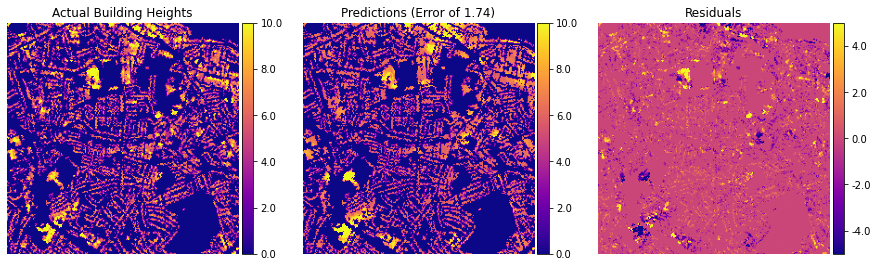

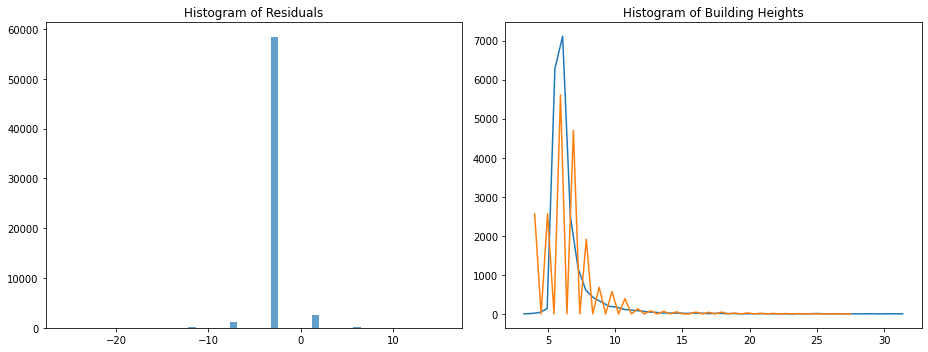

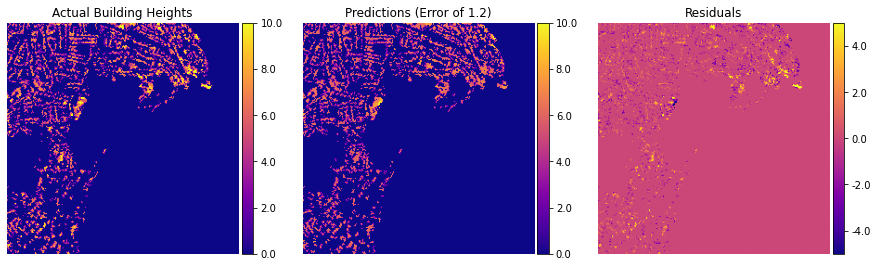

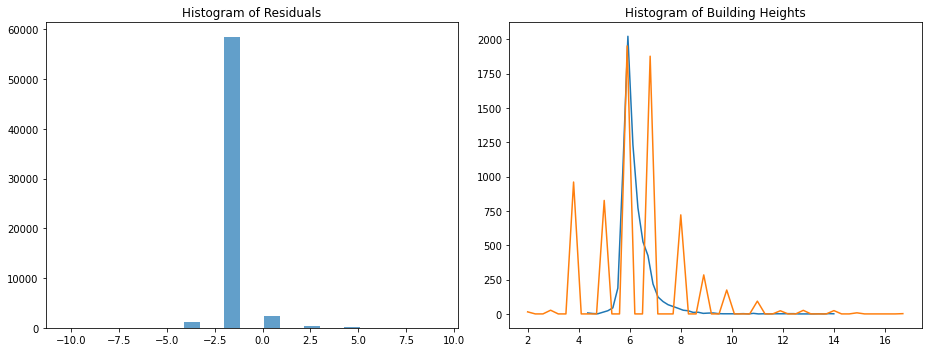

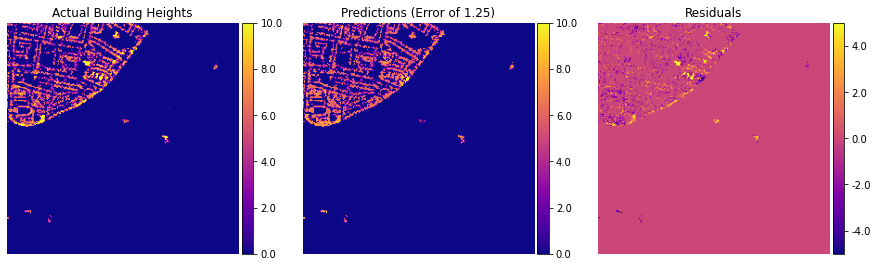

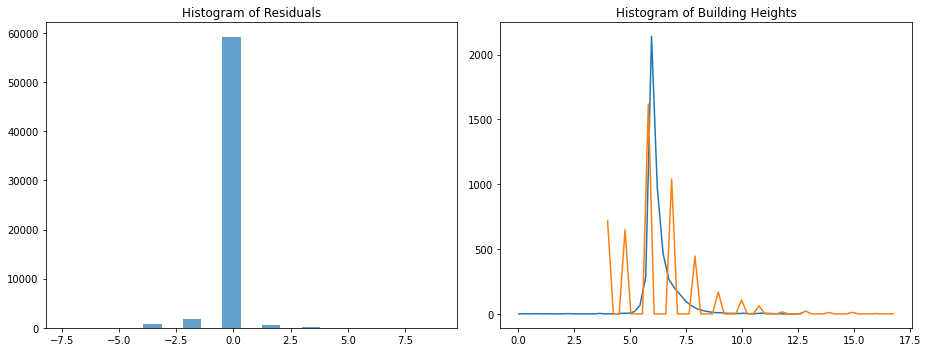

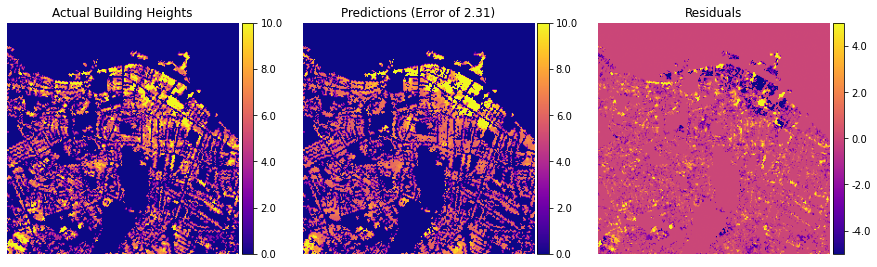

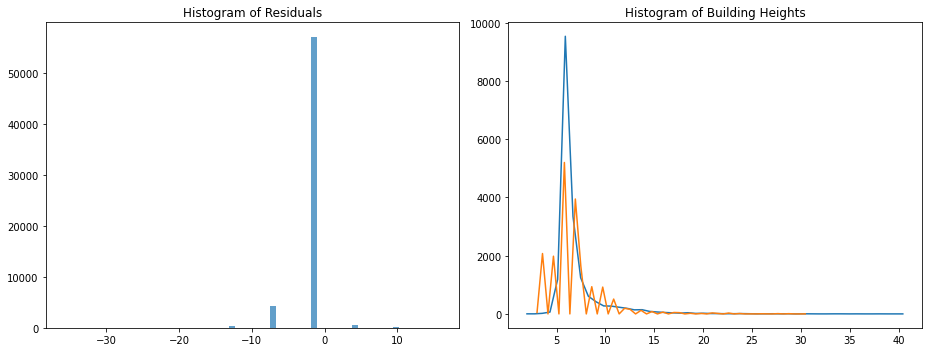

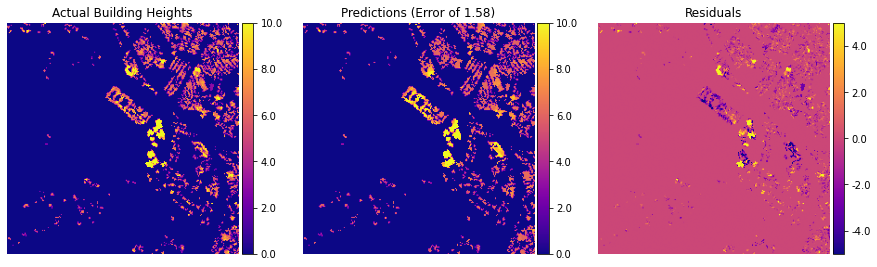

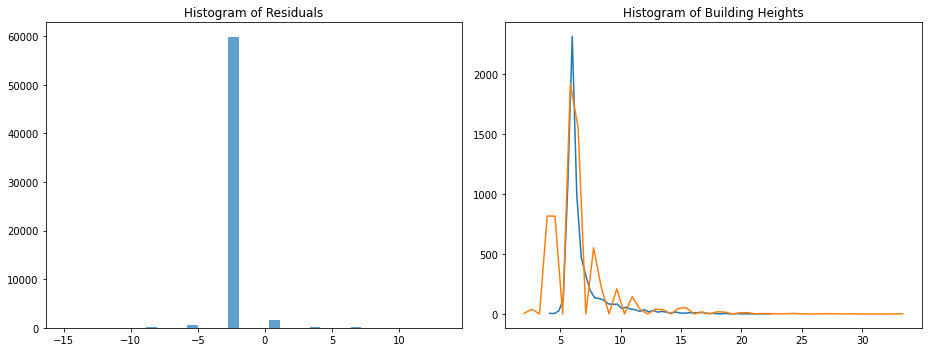

In [98]:
features = ['2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0001_CLS_asc','2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0007_CLS_asc',
            '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0012_CLS_asc',
            '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0001_CLS_asc','2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0006_CLS_asc',
            '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0011_CLS_asc','2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0001_DIL_asc',
            '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0002_DIL_asc','2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0003_DIL_asc',
            '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0007_DIL_asc','2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0012_DIL_asc',
            '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0001_DIL_asc','2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0003_DIL_asc',
            '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0005_DIL_asc','2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0007_DIL_asc',
            '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0012_DIL_asc','2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0003_ERO_asc',
            '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0009_ERO_asc','2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0001_GRD_asc',
            '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0005_GRD_asc','2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0012_GRD_asc',
            '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0002_GRD_asc','2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0003_GRD_asc',
            '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0004_GRD_asc','2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0006_GRD_asc',
            '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0007_GRD_asc','2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0008_GRD_asc',
            '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0001_OPN_asc','2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0005_OPN_asc',
            '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0007_OPN_asc','2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0011_OPN_asc',
            '2020-2020_001-365_HL_TSA_SEN2L_TCG_STM_B0003_BHT','2020-2020_001-365_HL_TSA_SEN2L_BNR_STM_B0002_CLS',
            '2020-2020_001-365_HL_TSA_SEN2L_NDB_STM_B0011_CLS','2020-2020_001-365_HL_TSA_SEN2L_NIR_STM_B0002_CLS',
            '2020-2020_001-365_HL_TSA_SEN2L_RE1_STM_B0001_CLS','2020-2020_001-365_HL_TSA_SEN2L_TCB_STM_B0012_CLS',
            '2020-2020_001-365_HL_TSA_SEN2L_NDB_STM_B0007_DIL','2020-2020_001-365_HL_TSA_SEN2L_NDW_STM_B0001_DIL',
            '2020-2020_001-365_HL_TSA_SEN2L_NDW_STM_B0004_DIL','2020-2020_001-365_HL_TSA_SEN2L_TCB_STM_B0009_DIL',
            '2020-2020_001-365_HL_TSA_SEN2L_BNR_STM_B0004_ERO','2020-2020_001-365_HL_TSA_SEN2L_BNR_STM_B0005_ERO',
            '2020-2020_001-365_HL_TSA_SEN2L_GRN_STM_B0004_ERO','2020-2020_001-365_HL_TSA_SEN2L_NDV_STM_B0007_ERO',
            '2020-2020_001-365_HL_TSA_SEN2L_NDW_STM_B0013_ERO','2020-2020_001-365_HL_TSA_SEN2L_NIR_STM_B0001_ERO',
            '2020-2020_001-365_HL_TSA_SEN2L_NIR_STM_B0002_ERO','2020-2020_001-365_HL_TSA_SEN2L_NIR_STM_B0003_ERO',
            '2020-2020_001-365_HL_TSA_SEN2L_NIR_STM_B0004_ERO','2020-2020_001-365_HL_TSA_SEN2L_NIR_STM_B0007_ERO',
            '2020-2020_001-365_HL_TSA_SEN2L_RE1_STM_B0011_ERO','2020-2020_001-365_HL_TSA_SEN2L_RE2_STM_B0008_ERO',
            '2020-2020_001-365_HL_TSA_SEN2L_SW1_STM_B0002_ERO','2020-2020_001-365_HL_TSA_SEN2L_SW1_STM_B0003_ERO',
            '2020-2020_001-365_HL_TSA_SEN2L_SW1_STM_B0004_ERO','2020-2020_001-365_HL_TSA_SEN2L_SW1_STM_B0007_ERO',
            '2020-2020_001-365_HL_TSA_SEN2L_SW2_STM_B0002_ERO','2020-2020_001-365_HL_TSA_SEN2L_TCB_STM_B0004_ERO',
            '2020-2020_001-365_HL_TSA_SEN2L_TCB_STM_B0013_ERO','2020-2020_001-365_HL_TSA_SEN2L_TCG_STM_B0006_ERO',
            '2020-2020_001-365_HL_TSA_SEN2L_TCW_STM_B0012_ERO','2020-2020_001-365_HL_TSA_SEN2L_GRN_STM_B0004_GRD',
            '2020-2020_001-365_HL_TSA_SEN2L_NDV_STM_B0007_GRD','2020-2020_001-365_HL_TSA_SEN2L_RE2_STM_B0011_GRD',
            '2020-2020_001-365_HL_TSA_SEN2L_TCW_STM_B0007_GRD','2020-2020_001-365_HL_TSA_SEN2L_BNR_STM_B0004_OPN',
            '2020-2020_001-365_HL_TSA_SEN2L_NDW_STM_B0013_OPN','2020-2020_001-365_HL_TSA_SEN2L_NIR_STM_B0012_OPN',
            '2020-2020_001-365_HL_TSA_SEN2L_RE1_STM_B0011_OPN','2020-2020_001-365_HL_TSA_SEN2L_SW1_STM_B0012_OPN',
            '2020-2020_001-365_HL_TSA_SEN2L_TCG_STM_B0003_OPN','2020-2020_001-365_HL_TSA_SEN2L_TCG_STM_B0008_OPN',
            ]


feature_order = ['2020-2020_001-365_HL_TSA_SEN2L_NDV_STM_B0007_GRD','2020-2020_001-365_HL_TSA_SEN2L_NDV_STM_B0007_ERO',
                 '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0011_OPN_asc','2020-2020_001-365_HL_TSA_SEN2L_BNR_STM_B0002_CLS',
                 '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0003_DIL_asc','2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0003_GRD_asc',
                 '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0011_CLS_asc','2020-2020_001-365_HL_TSA_SEN2L_TCG_STM_B0008_OPN',
                 '2020-2020_001-365_HL_TSA_SEN2L_BNR_STM_B0004_OPN','2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0001_DIL_asc',
                 '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0012_DIL_asc','2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0006_GRD_asc',
                 '2020-2020_001-365_HL_TSA_SEN2L_SW1_STM_B0002_ERO','2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0007_DIL_asc',
                 '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0002_GRD_asc','2020-2020_001-365_HL_TSA_SEN2L_NDW_STM_B0001_DIL',
                 '2020-2020_001-365_HL_TSA_SEN2L_BNR_STM_B0005_ERO','2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0005_GRD_asc',
                 '2020-2020_001-365_HL_TSA_SEN2L_GRN_STM_B0004_ERO','2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0002_DIL_asc',
                 '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0012_DIL_asc','2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0001_DIL_asc',
                 '2020-2020_001-365_HL_TSA_SEN2L_SW1_STM_B0012_OPN','2020-2020_001-365_HL_TSA_SEN2L_NIR_STM_B0003_ERO',
                 '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0003_ERO_asc','2020-2020_001-365_HL_TSA_SEN2L_TCW_STM_B0012_ERO',
                 '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0005_DIL_asc','2020-2020_001-365_HL_TSA_SEN2L_NIR_STM_B0007_ERO',
                 '2020-2020_001-365_HL_TSA_SEN2L_BNR_STM_B0004_ERO','2020-2020_001-365_HL_TSA_SEN2L_TCG_STM_B0006_ERO',
                 '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0005_OPN_asc','2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0007_DIL_asc',
                 '2020-2020_001-365_HL_TSA_SEN2L_NDB_STM_B0007_DIL','2020-2020_001-365_HL_TSA_SEN2L_NIR_STM_B0004_ERO',
                 '2020-2020_001-365_HL_TSA_SEN2L_NDW_STM_B0013_ERO','2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0001_CLS_asc',
                 '2020-2020_001-365_HL_TSA_SEN2L_GRN_STM_B0004_GRD','2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0001_OPN_asc',
                 '2020-2020_001-365_HL_TSA_SEN2L_NDW_STM_B0004_DIL','2020-2020_001-365_HL_TSA_SEN2L_NIR_STM_B0012_OPN',
                 '2020-2020_001-365_HL_TSA_SEN2L_SW2_STM_B0002_ERO','2020-2020_001-365_HL_TSA_SEN2L_TCB_STM_B0009_DIL',
                 '2020-2020_001-365_HL_TSA_SEN2L_NIR_STM_B0002_ERO','2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0006_CLS_asc',
                 '2020-2020_001-365_HL_TSA_SEN2L_NDW_STM_B0013_OPN','2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0003_DIL_asc',
                 '2020-2020_001-365_HL_TSA_SEN2L_TCW_STM_B0007_GRD','2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0012_CLS_asc',
                 '2020-2020_001-365_HL_TSA_SEN2L_RE2_STM_B0011_GRD','2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0004_GRD_asc',
                 '2020-2020_001-365_HL_TSA_SEN2L_TCB_STM_B0012_CLS','2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0008_GRD_asc',
                 '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0012_GRD_asc','2020-2020_001-365_HL_TSA_SEN2L_RE1_STM_B0001_CLS',
                 '2020-2020_001-365_HL_TSA_SEN2L_TCG_STM_B0003_OPN','2020-2020_001-365_HL_TSA_SEN2L_TCG_STM_B0003_BHT',
                 '2020-2020_001-365_HL_TSA_SEN2L_SW1_STM_B0003_ERO','2020-2020_001-365_HL_TSA_SEN2L_NIR_STM_B0002_CLS',
                 '2020-2020_001-365_HL_TSA_SEN2L_NDB_STM_B0011_CLS','2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0009_ERO_asc',
                 '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0007_CLS_asc','2020-2020_001-365_HL_TSA_SEN2L_SW1_STM_B0007_ERO',
                 '2020-2020_001-365_HL_TSA_SEN2L_TCB_STM_B0013_ERO','2020-2020_001-365_HL_TSA_SEN2L_SW1_STM_B0004_ERO',
                 '2020-2020_001-365_HL_TSA_SEN2L_RE1_STM_B0011_ERO','2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0001_GRD_asc',
                 '2020-2020_001-365_HL_TSA_SEN2L_RE1_STM_B0011_OPN','2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0001_CLS_asc',
                 '2020-2020_001-365_HL_TSA_SEN2L_TCB_STM_B0004_ERO','2020-2020_001-365_HL_TSA_SEN2L_NIR_STM_B0001_ERO',
                 '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0007_OPN_asc','2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0007_GRD_asc',
                 '2020-2020_001-365_HL_TSA_SEN2L_RE2_STM_B0008_ERO']


def replace_value_with_frequency_of_occurance(array):

    unique_elements, counts_elements = np.unique(array, return_counts=True)
    mapping = dict(zip(unique_elements, counts_elements))
    
    return np.vectorize(mapping.get)(array)



def weighted_root_mean_squared_error(y_actual, y_pred):
    
    y_actual = y_actual.flatten()
    y_pred   = y_pred.flatten()
    
    y_pred   = y_pred[y_actual > 0]
    y_actual = y_actual[y_actual > 0]
   
    weights = replace_value_with_frequency_of_occurance(y_actual)
    
    return np.sqrt(np.sum(weights * ((y_pred - y_actual) ** 2)) / np.sum(weights))



def load_model(filename):
    '''
    load the xgboost model
    '''
    model = XGBRegressor()
    model.load_model(filename)
    return model



def make_segment_wide_prediction(img_volume, building_heights, model, features):
    '''
    loop through an image pixel by pixel and make predictions
    save these predictions in a numpy array
    '''
    width, height, channels = img_volume.shape
    predictions = np.zeros((width, height, 1))
    
    for point_X in range(width):
        for point_Y in range(height):
        
            # if building height map non zero than make a prediction
            if building_heights[point_X,point_Y,0] > 0:
                pixel = img_volume[point_X,point_Y,:]
                pixel_data = pd.DataFrame(data=[pixel], columns=features)[feature_order]
                predictions[point_X, point_Y,0] = model.predict(pixel_data)
    
    
    return predictions



def visulaize_predictions(model, features):
    
    data  = DataGenerator().__getitem__(1)
    
    for i in range(len(data[0])):
    
        X = data[0][i]
        y = data[1][i]
        
        preds = make_segment_wide_prediction(X, y, model, features)
        height_image = y
        residuals = height_image-preds
        
        error = round(weighted_root_mean_squared_error(height_image, preds),2)
        
        fig = plt.figure(figsize=(15, 15))
        
        ax1 = fig.add_subplot(1,3,1)
        ax1.axis('off')
        ax1.set_title("Actual Building Heights")
        img1 = ax1.imshow(height_image, vmin=0, vmax=10, cmap='plasma')
        
        ax2 = fig.add_subplot(1,3,2)
        ax2.axis('off')
        ax2.set_title(f"Predictions (Error of {error})")
        img2 = ax2.imshow(preds, vmin=0, vmax=10, cmap='plasma')
        
        
        ax3 = fig.add_subplot(1,3,3)
        ax3.axis('off')
        ax3.set_title(f"Residuals")
        img3 = ax3.imshow(residuals, vmin=-5, vmax=5, cmap='plasma')
        
        fig2 = plt.figure(figsize=(13, 5))
        
        ax4 = fig2.add_subplot(1,2,1)
        ax4.set_title(f"Histogram of Residuals")
        hist, bin_edges = np.histogram(residuals)
        ax4.bar(bin_edges[:-1], hist, alpha=0.7)
        
        
        ax5 = fig2.add_subplot(1,2,2)
        ax5.set_title(f"Histogram of Building Heights")

        height_image = height_image.flatten()
        preds = preds.flatten()

        preds  = preds[height_image > 0]
        height_image  = height_image[height_image > 0]
        
        hist_preds, bin_edges_preds   = np.histogram(preds, 50)
        hist_actual, bin_edges_actual = np.histogram(height_image, 50)

        ax5.plot(bin_edges_preds[:-1], hist_preds)
        ax5.plot(bin_edges_actual[:-1], hist_actual)

        
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        divider1 = make_axes_locatable(ax1)
        cax1 = divider1.append_axes("right", size="5%", pad=0.05)
        
        divider2 = make_axes_locatable(ax2)
        cax2 = divider2.append_axes("right", size="5%", pad=0.05)
        
        divider3 = make_axes_locatable(ax3)
        cax3 = divider3.append_axes("right", size="5%", pad=0.05)

        
        fig.colorbar(img1,cax=cax1,  format='%.1f')
        fig.colorbar(img2,cax=cax2,  format='%.1f')
        fig.colorbar(img3,cax=cax3,  format='%.1f')

        plt.tight_layout(h_pad=1)
        
       
        
xgb_test = load_model("xgb_building_height.json")
visulaize_predictions(model=xgb_test, features=features)